In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 1. Download the dataset: Dataset


# 2. Load the dataset into the tool.

In [4]:
df = pd.read_csv("E:\\IBM projects Assignment Sona College\\abalone.csv")

# 3. Perform Below Visualizations.
## ∙ Univariate Analysis
## ∙ Bi-Variate Analysis
## ∙ Multi-Variate Analysis

In [5]:
#rename output variable
df.rename(columns={"Sex":"sex", "Length":"length", "Diameter":"diameter",
                   "Height":"height", "Whole weight":"whole_weight",
                   "Shucked weight":"shucked_weight", "Viscera weight":"viscera_weight",
                   "Shell weight":"shell_weight", "Rings":"rings"}, inplace = True)

In [6]:
df[df['height'] == 0]  #need to drop these rows.
df.drop(index=[1257,3996], inplace = True)
df.shape

(4175, 9)

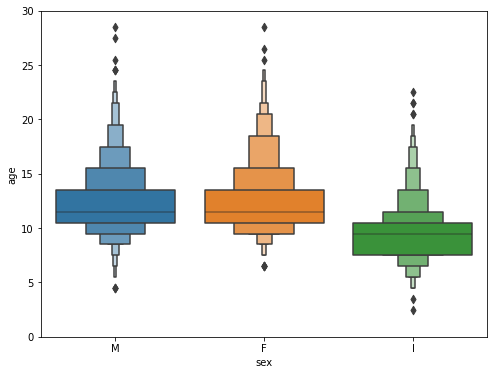

In [7]:
df['age'] = df['rings']+1.5 #AS per the problem statement
df.drop('rings', axis = 1, inplace = True)
df.head()
#categorical features
temp = pd.concat([df['age'], df['sex']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxenplot(x='sex', y="age", data=df)
fig.axis(ymin=0, ymax=30);

### ANALYSIS

#### There is no difference in age of rings for male and female (8-19). But in infants, it lies between (5-10)
### Count Plot

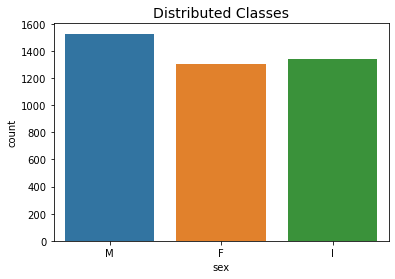

In [8]:
sns.countplot('sex', data=df)
plt.title('Distributed Classes', fontsize=14)
plt.show()

#### Histograms: Understanding the Distribution of the Numerical Features

array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'diameter'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'whole_weight'}>],
       [<AxesSubplot:title={'center':'shucked_weight'}>,
        <AxesSubplot:title={'center':'viscera_weight'}>,
        <AxesSubplot:title={'center':'shell_weight'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

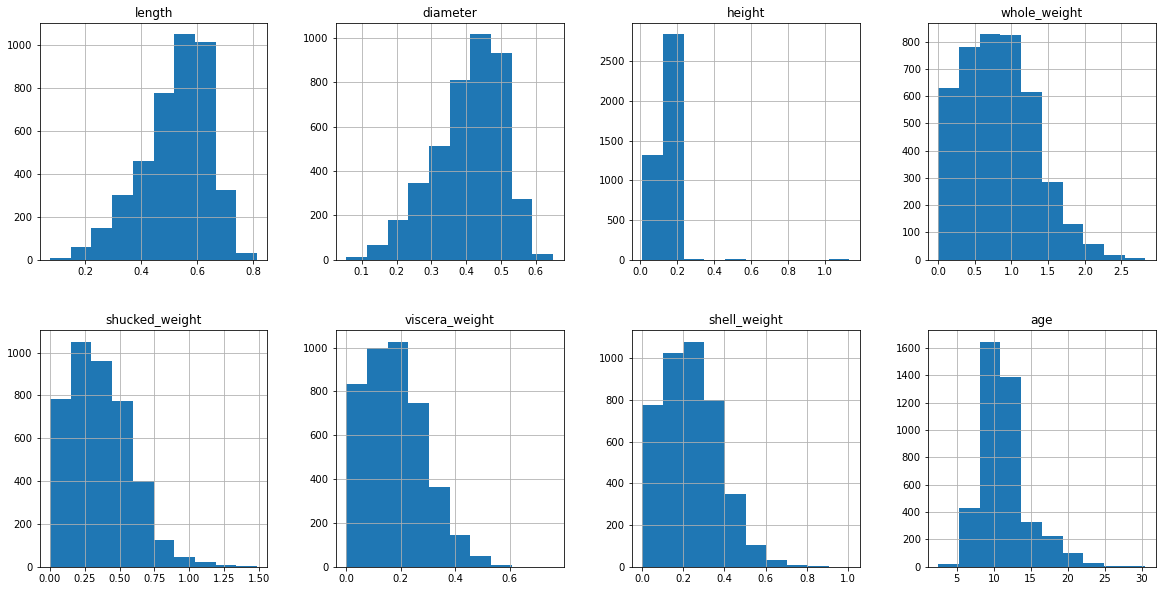

In [9]:
df.hist(figsize = (20,10), layout = (2,4))

#### ANALYSIS

- Skewness of the height is too high. (need to normalise later...)
Need to check skewness for all varibles
#### Skewness of the Variables

In [10]:
df.skew().sort_values(ascending = False)

height            3.166364
age               1.113754
shucked_weight    0.718735
shell_weight      0.621081
viscera_weight    0.591455
whole_weight      0.530549
diameter         -0.610182
length           -0.640993
dtype: float64

#### ANALYSIS:

- Skewness is close to 0 for Normal distribution curve.
- Height has the highest skewness of 3.17.
- May be there are outliers in height, we need to check that and remove them before modeling.
- Will check the coorelation with the dependent variable (Rings)
- Will use IQR algorithm to remove outliers.

#### Coorelation Plot

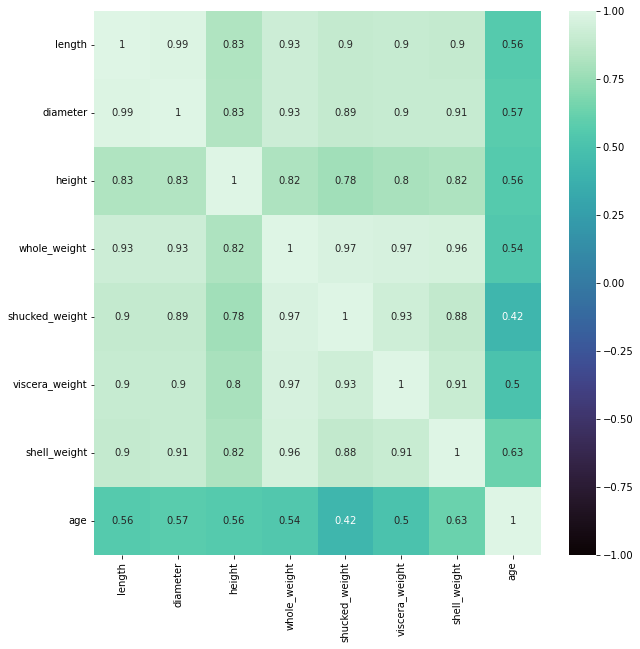

In [11]:
corr = df.corr()
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr, vmin = -1, center = 0, annot = True, cmap = 'mako')

#### ANALYSIS

- No Negative correlation found
- High coorelation between Length & Diameter
- High corelation between shucked weight, viscera weight Vs Whole_weight & Shell weight vs Whole_weight

In [12]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
columns_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)] #highly correlated variables to be removed.

print("Columns to drop:\n", columns_to_drop)


Columns to drop:
 ['diameter', 'shucked_weight', 'viscera_weight', 'shell_weight']


#### ANALYSIS

- We will remove the above columns, before proceeding any further.

## 4. Perform descriptive statistics on the dataset.

In [13]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [14]:
df.shape

(4175, 9)

In [15]:
df.describe()


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
count,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,11.435090
std,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227
min,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,9.500000
50%,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,10.500000
75%,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,12.500000
max,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4175 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4175 non-null   object 
 1   length          4175 non-null   float64
 2   diameter        4175 non-null   float64
 3   height          4175 non-null   float64
 4   whole_weight    4175 non-null   float64
 5   shucked_weight  4175 non-null   float64
 6   viscera_weight  4175 non-null   float64
 7   shell_weight    4175 non-null   float64
 8   age             4175 non-null   float64
dtypes: float64(8), object(1)
memory usage: 326.2+ KB


## 5. Check for Missing values and deal with them.

In [17]:
df[df.duplicated()]


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age


In [18]:
df.isna().sum()


sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
age               0
dtype: int64

#### there is no missing values and duplicates in dataframe


## 6. Find the outliers and replace them outliers

In [19]:
for i in df:
    if df[i].dtype=='int64' or df[i].dtypes=='float64':
        q1=df[i].quantile(0.25)
        q3=df[i].quantile(0.75)
        iqr=q3-q1
        upper=q3+1.5*iqr
        lower=q1-1.5*iqr
        df[i]=np.where(df[i] >upper, upper, df[i])
        df[i]=np.where(df[i] <lower, lower, df[i])

### After removing outliers, boxplot will be like

In [20]:
import matplotlib.pyplot as mtp

In [21]:
def box_scatter(data, x, y):    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
    sns.boxplot(data=data, x=x, ax=ax1)
    sns.scatterplot(data=data, x=x,y=y,ax=ax2)


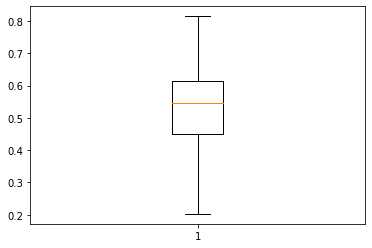

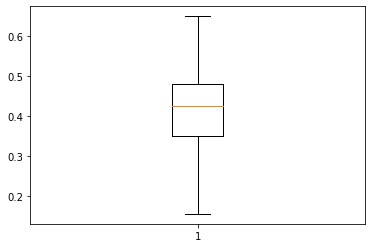

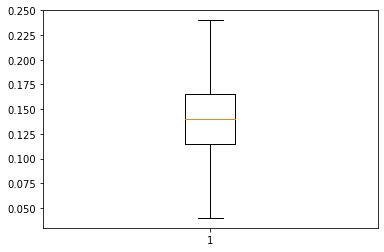

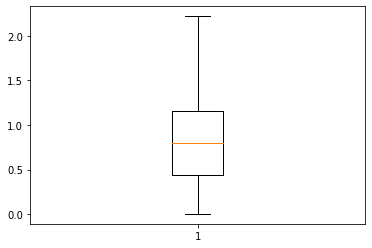

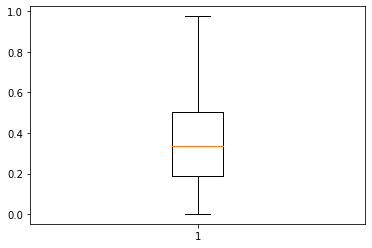

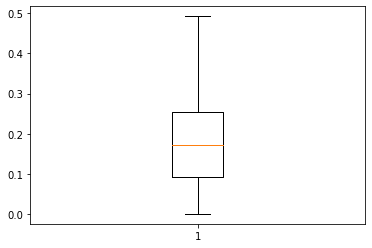

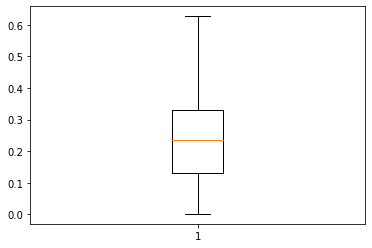

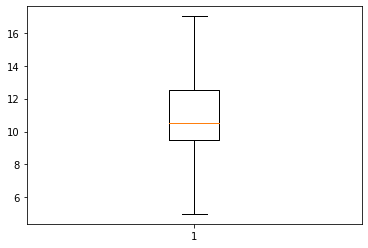

In [22]:
for i in df:
    if df[i].dtype=='int64' or df[i].dtypes=='float64':
        mtp.boxplot(df[i])
        mtp.show()

# 7. Check for Categorical columns and perform encoding.

In [23]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [24]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['sex']=encoder.fit_transform(df['sex'])


In [25]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


# 8. Split the data into dependent and independent variables.

In [26]:
x=df.iloc[:,:-1]
x.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [27]:
y=df.iloc[:,-1]
y.head()

0    16.5
1     8.5
2    10.5
3    11.5
4     8.5
Name: age, dtype: float64

# 9. Scale the independent variable

In [28]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x=scaler.fit_transform(x)

# 10. Split the data into training and testing

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33)

In [30]:
x_train.shape

(2797, 8)

In [31]:
x_test.shape


(1378, 8)

# 11. Build the Model

In [32]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor()

# 12. Train the Model

In [33]:
reg.fit(x_train,y_train)


RandomForestRegressor()

#### In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.


# 13. Test the Model

In [34]:
y_pred=reg.predict(x_test)


# 14. Measure the performance using Metrics.

In [35]:
from sklearn.metrics import mean_squared_error
import math
print(math.sqrt(mean_squared_error(y_test,y_pred)))

1.6928627281192774
